In [1]:
# start a Spak session
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("yelp-review") \
    .getOrCreate()

# get a spark context from the session, and set verbose logging
sc = spark.sparkContext
sc.setLogLevel("ERROR")
sc

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/19 22:16:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<SparkContext master=local[*] appName=yelp-review>

In [2]:
from pyspark.sql.functions import * 

In [3]:
df = spark.read\
    .option("header","true")\
    .option("inferSchema","true")\
    .json('shared/student-data/yelp/yelp_academic_dataset_review.json')

In [4]:
df.cache()
df1 = df.select(['stars', 'text'])
df1.show(5)

+-----+--------------------+
|stars|                text|
+-----+--------------------+
|  4.0|Apparently Prides...|
|  4.0|This store is pre...|
|  5.0|I called WVM on t...|
|  2.0|I've stayed at ma...|
|  4.0|The food is alway...|
+-----+--------------------+
only showing top 5 rows



In [5]:
df1.groupBy('stars').count().sort('stars').show()

+-----+-------+
|stars|  count|
+-----+-------+
|  1.0|1262800|
|  2.0| 711378|
|  3.0| 926656|
|  4.0|1920037|
|  5.0|3814532|
+-----+-------+



In [6]:
import pyspark.sql.functions as F
df1.select('stars','text')\
            .withColumn('length', F.length('text'))\
            .groupBy('stars')\
            .agg(F.round(F.stddev('length'),2).alias('std_dev'),
                 F.round(F.skewness('length'),2).alias('skew'),
                 F.round(F.kurtosis('length'),2).alias('kurtosis'))\
            .sort('stars')\
            .show()

+-----+-------+----+--------+
|stars|std_dev|skew|kurtosis|
+-----+-------+----+--------+
|  1.0| 711.22|2.41|    7.85|
|  2.0|  648.4|2.25|    7.44|
|  3.0| 589.97|2.29|    8.19|
|  4.0| 533.98|2.44|    9.64|
|  5.0| 457.63|2.95|   14.25|
+-----+-------+----+--------+



In [7]:
review = df1.select(['stars', 'text'])

In [8]:
review_sample1 = review.sample(False, 0.001)

In [9]:
review_sample1.show(5)

+-----+--------------------+
|stars|                text|
+-----+--------------------+
|  5.0|As a native of th...|
|  5.0|OMG I just love t...|
|  2.0|I stay in a lot o...|
|  3.0|Busy bee was my g...|
|  2.0|Courteous staff. ...|
+-----+--------------------+
only showing top 5 rows



In [10]:
review_sample1.cache()
review_sample1.count()

8666

In [11]:
review_sample1.groupBy('stars').count().sort('stars').show()

+-----+-----+
|stars|count|
+-----+-----+
|  1.0| 1235|
|  2.0|  696|
|  3.0|  891|
|  4.0| 1873|
|  5.0| 3971|
+-----+-----+



In [12]:
review_sample1.printSchema()

root
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)



In [13]:
import pyspark.sql.functions as F
review_sample1.select('stars','text')\
            .withColumn('length', F.length('text'))\
            .groupBy('stars')\
            .agg(F.round(F.stddev('length'),2).alias('std_dev'),
                 F.round(F.skewness('length'),2).alias('skew'),
                 F.round(F.kurtosis('length'),2).alias('kurtosis'))\
            .sort('stars')\
            .show()

+-----+-------+----+--------+
|stars|std_dev|skew|kurtosis|
+-----+-------+----+--------+
|  1.0| 722.52|2.21|    6.55|
|  2.0| 707.53|2.18|    6.63|
|  3.0| 601.84|2.33|     8.0|
|  4.0|  520.9|2.42|    9.79|
|  5.0| 474.14|3.01|    14.6|
+-----+-------+----+--------+



In [14]:


stats = review_sample1.select('text')\
            .withColumn('length', F.length('text'))\
            .agg(min(col('length')).alias('min'), 
                 max(col('length')).alias('max'), 
                 avg(col('length')).alias('mean'), 
                 F.percentile_approx('length', 0.5).alias('median'), 
                 F.stddev('length').alias('std'))\
            .collect()
min_length = stats[0]['min']
max_length = stats[0]['max']
mean_length = stats[0]['mean']
median_length = stats[0]['median']
std_length = stats[0]['std']

In [15]:
fixed_length_bucket = []
stddev_based_bucket = [mean_length]

num_bucket = 6
fixed_length = (max_length - min_length) / num_bucket
curr_length = 0
for i in range(num_bucket+1):
    fixed_length_bucket.append(curr_length)
    curr_length += fixed_length
    
fixed_length_bucket[-1] = max_length + 1


curr_length = mean_length - std_length
for i in range(num_bucket//2):
    stddev_based_bucket.append(curr_length)
    curr_length -= std_length
    if curr_length < 0:
        stddev_based_bucket.append(0)
        break

stddev_based_bucket = stddev_based_bucket[::-1]
curr_length = mean_length + std_length
for i in range(num_bucket//2+1):
    stddev_based_bucket.append(curr_length)
    curr_length += std_length
    if curr_length > max_length:
        break
stddev_based_bucket[0] = 0
stddev_based_bucket[-1] = max_length + 1

print(fixed_length_bucket)
print(stddev_based_bucket)

[0, 826.6666666666666, 1653.3333333333333, 2480.0, 3306.6666666666665, 4133.333333333333, 5000]
[0, 39.170870018764504, 610.5995845834295, 1182.0282991480944, 1753.4570137127594, 2324.8857282774243, 5000]


In [16]:
# library to clean data
import re

# Natural Language Tool Kit
import nltk

nltk.download('stopwords')

# to remove stopword
from nltk.corpus import stopwords

# for Stemming propose
from nltk.stem.porter import PorterStemmer


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
from collections import deque
from itertools import chain
stopwords_list = stopwords.words('english')
sc.broadcast(stopwords_list)
sc.broadcast(fixed_length_bucket)
sc.broadcast(stddev_based_bucket)

def build_ngrams(features, data, n):
    if not data:
        return
    data = data.lower().strip()
    data = re.sub("[^0-9a-zA-Z]+", " ", data)
    data = data.split(" ")
    ps = PorterStemmer()
    
    # loop for stemming each word
    # in string array at ith row
    data = [ps.stem(word) for word in data
                if not word in set(stopwords_list)]

    word_list = deque()
    for i, word in enumerate(data):
        # if word in 
        # add word to word_list if length of word list smaller than 2
        if word == '' or word == ' ' or not word:
            continue

        if (len(word_list) < n):
            word_list.append(word)


        # generate a key string if word_list has length of 2
        if (len(word_list) == n):
            # key string
            key_word = ' '.join(word_list)
            # pop the first element out of the queue, O(1)
            word_list.popleft()
            if key_word in features:
                features[key_word] += 1
            else:
                features[key_word] = 1

        # if end of current iteration, empty queue, to avoid cross line counting
        if i == len(data) - 1:
            word_list = deque()
    

def build_uni_features(data):
    features = {}
    build_ngrams(features, data, 1)
    return features

def build_bi_features(data):
    features = {}
    build_ngrams(features, data, 2)
    return features

def build_tri_features(data):
    features = {}
    build_ngrams(features, data, 3)
    return features


def assign_fixed_length_bucket(data):
    for i, l in enumerate(fixed_length_bucket):
        if data < l:
            return i
    return i

def assign_stddev_based_bucket(data):
    for i, l in enumerate(stddev_based_bucket):
        if int(data) <= float(l):
            return i
    return i

In [18]:
create_unigram_udf = udf(build_uni_features)
create_bigram_udf = udf(build_bi_features)
create_trigram_udf = udf(build_tri_features)
create_fixed_length_bucket_udf = udf(assign_fixed_length_bucket)
create_stddev_based_bucket_udf = udf(assign_stddev_based_bucket)
review_sample1.na.drop()


DataFrame[stars: double, text: string]

In [19]:
review_sample_2 = review_sample1.select(['stars', 
                                         create_unigram_udf('text').alias('unigram'), 
                                         create_bigram_udf('text').alias('bigram'), 
                                         create_trigram_udf('text').alias('trigram'), 
                                         create_stddev_based_bucket_udf(F.length('text')).alias('length')
                                        ])


In [20]:
review_sample_2.cache()
review_sample_2.show(5)

+-----+--------------------+--------------------+--------------------+------+
|stars|             unigram|              bigram|             trigram|length|
+-----+--------------------+--------------------+--------------------+------+
|  5.0|{area=1, new=1, d...|{world home=1, bi...|{biscuit world ho...|     2|
|  5.0|{organ=1, love=2,...|{look good=1, imp...|{new knowledg wor...|     2|
|  2.0|{properti=2, cons...|{front desk=1, al...|{make work bother...|     2|
|  3.0|{servic=1, bee=1,...|{food year=1, yea...|{food year food=1...|     2|
|  2.0|{minut=2, 45=1, d...|{driver decent=1,...|{45 minut argu=1,...|     2|
+-----+--------------------+--------------------+--------------------+------+
only showing top 5 rows



In [21]:
review_sample_2.first()

Row(stars=5.0, unigram='{area=1, new=1, delici=1, crowd=1, made=1, tell=1, amaz=1, orlean=1, food=1, home=1, world=1, charm=1, nativ=1, jam=1, legit=1, biscuit=1}', bigram='{world home=1, biscuit world=1, nativ new=1, food legit=1, made jam=1, legit delici=1, area tell=1, new orlean=1, charm biscuit=1, crowd charm=1, home made=1, delici amaz=1, orlean area=1, tell food=1, amaz crowd=1}', trigram='{biscuit world home=1, crowd charm biscuit=1, legit delici amaz=1, home made jam=1, amaz crowd charm=1, charm biscuit world=1, orlean area tell=1, nativ new orlean=1, world home made=1, food legit delici=1, area tell food=1, delici amaz crowd=1, tell food legit=1, new orlean area=1}', length='2')

In [22]:
label = review_sample_2.rdd.map(lambda x: x['stars']).collect()
unigram = review_sample_2.rdd.map(lambda x: x['unigram']).collect()
bigram = review_sample_2.rdd.map(lambda x: x['bigram']).collect()
trigram = review_sample_2.rdd.map(lambda x: x['trigram']).collect()
length = review_sample_2.rdd.map(lambda x: x['length']).collect()

In [23]:
# for each rating, decrement it by 1.0, 
# rating 1.0 === label 0.0
# rating 2.0 === label 1.0
# rating 3.0 === label 2.0
# rating 4.0 === label 3.0
# rating 5.0 === label 4.0

label = [i - 1 for i in label]

In [24]:
print(len(label), type(label))
print(len(unigram), type(unigram))
print(len(bigram), type(bigram))
print(len(trigram), type(trigram))
print(len(length), type(length))

8666 <class 'list'>
8666 <class 'list'>
8666 <class 'list'>
8666 <class 'list'>
8666 <class 'list'>


In [25]:
# currently the dictionary is a string type
print(unigram[:5], type(unigram[0]))

['{area=1, new=1, delici=1, crowd=1, made=1, tell=1, amaz=1, orlean=1, food=1, home=1, world=1, charm=1, nativ=1, jam=1, legit=1, biscuit=1}', '{organ=1, love=2, skin=1, omg=1, recommend=1, best=1, turn=1, good=1, dr=1, result=1, bali=1, sever=1, place=1, wonder=1, leav=1, realli=1, carolin=1, owner=1, new=1, product=1, spa=2, work=1, overal=1, also=1, puberti=1, say=1, improv=1, clean=1, look=3, onto=1, highli=1, face=2, hauschka=1, knowledg=1, know=1, hydrafaci=1, probabl=1, fresh=1, sinc=1, stuff=1}', '{properti=2, consist=1, seem=1, lot=1, waffl=1, sheet=1, make=1, wifi=1, bother=1, work=2, night=1, one=1, inn=2, maker=1, come=1, also=1, check=1, less=2, blood=1, stay=1, welcom=1, pretti=1, hampton=2, desk=1, know=1, personnel=1, except=1, front=1, much=2, typic=1, qualiti=1}', '{servic=1, bee=1, year=1, pricey=1, get=1, busi=1, go=1, place=1, bit=1, declin=1, food=3}', '{minut=2, 45=1, door=1, big=1, shuttl=3, wait=1, away=1, bad=2, almost=1, recommend=1, decent=1, hour=1, would=2

In [26]:
# process each string to create a dictionary of word count

import json
from collections import defaultdict

data = []
uni_features_dict = {}
bi_features_dict = {}
tri_features_dict = {}

def count_freq(counter, k, v):
    if k in counter:
        counter[k] += v
    else:
        counter[k] = v
    return

def process_dict(data):
    global uni_features_dict, bi_features_dict, tri_features_dict
    features = defaultdict(int)
    data = data.split(', ')
    for d in data:
        if '=' not in d:
            continue
        k, v = d.split('=')
        count = int(v.strip())
        ngram = k.split(' ')
        length = len(ngram)
        if length == 1:
            count_freq(uni_features_dict, k.strip(), count)
        elif length == 2:
            count_freq(bi_features_dict, k.strip(), count)
        elif length == 3:
            count_freq(tri_features_dict, k.strip(), count)
        features[k.strip()] = count
    return features


for i in range(len(label)):
    uni = process_dict(unigram[i][1:-1])
    bi = process_dict(bigram[i][1:-1])
    tri = process_dict(trigram[i][1:-1])
    features = {**uni, **bi, **tri, 'length':length[i]}
    data_point = (features, label[i])
    data.append(data_point)

# del unigram, bigram, label

In [27]:
len(data)

8666

In [28]:
# now features of each label point is a dictionary type

print(type(data[0][0]))
print(data[0])

<class 'dict'>
({'area': 1, 'new': 1, 'delici': 1, 'crowd': 1, 'made': 1, 'tell': 1, 'amaz': 1, 'orlean': 1, 'food': 1, 'home': 1, 'world': 1, 'charm': 1, 'nativ': 1, 'jam': 1, 'legit': 1, 'biscuit': 1, 'world home': 1, 'biscuit world': 1, 'nativ new': 1, 'food legit': 1, 'made jam': 1, 'legit delici': 1, 'area tell': 1, 'new orlean': 1, 'charm biscuit': 1, 'crowd charm': 1, 'home made': 1, 'delici amaz': 1, 'orlean area': 1, 'tell food': 1, 'amaz crowd': 1, 'biscuit world home': 1, 'crowd charm biscuit': 1, 'legit delici amaz': 1, 'home made jam': 1, 'amaz crowd charm': 1, 'charm biscuit world': 1, 'orlean area tell': 1, 'nativ new orlean': 1, 'world home made': 1, 'food legit delici': 1, 'area tell food': 1, 'delici amaz crowd': 1, 'tell food legit': 1, 'new orlean area': 1, 'length': '2'}, 4.0)


In [29]:
# this is a collective hashmap of all trigram word count in all label point
tri_features_dict

{'biscuit world home': 1,
 'crowd charm biscuit': 1,
 'legit delici amaz': 1,
 'home made jam': 1,
 'amaz crowd charm': 1,
 'charm biscuit world': 1,
 'orlean area tell': 1,
 'nativ new orlean': 1,
 'world home made': 1,
 'food legit delici': 1,
 'area tell food': 1,
 'delici amaz crowd': 1,
 'tell food legit': 1,
 'new orlean area': 1,
 'new knowledg work': 1,
 'realli know stuff': 2,
 'look good sinc': 1,
 'wonder organ product': 1,
 'result leav face': 1,
 'overal improv skin': 1,
 'look place overal': 1,
 'recommend bali spa': 1,
 'product dr hauschka': 1,
 'owner realli know': 1,
 'hauschka say face': 1,
 'spa carolin owner': 1,
 'stuff turn onto': 1,
 'highli recommend bali': 1,
 'best highli recommend': 4,
 'puberti also sever': 1,
 'carolin owner realli': 1,
 'skin new knowledg': 1,
 'omg love spa': 1,
 'sinc probabl puberti': 1,
 'face fresh clean': 1,
 'love spa carolin': 1,
 'leav face fresh': 1,
 'face look good': 1,
 'place overal improv': 1,
 'clean look look': 1,
 'hydra

## Selected Features

In [30]:
from sklearn.model_selection import train_test_split
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, MultilabelClassificationEvaluator
from pyspark.mllib.evaluation import MultilabelMetrics
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt


# we select only the features whose frequency passes certain threshold, which can be arbitrary.
# in this practice, we select unigram whose frequency is greater than 200, 
# and bigram whose frequence greater than 50, 
# and trigram whose frequence greater than 10
def build_data(data, selected_features):
    selected_data = []
    selected_data_no_length = []
    for data_point in data:
        label = data_point[1]
        features = data_point[0]
        new_features = []
        for f in selected_features:
            if f in features:
                new_features.append(1.0)
            else:
                new_features.append(0.0)
        new_features.append(features['length'])
        selected_data.append(LabeledPoint(label, new_features))
    return selected_data

def build_model(data, count, iterations=10):
    def build_features(features, count=100):
        uni_features_dict, bi_features_dict, tri_features_dict = features
        selected_uni_features = {k: v for k, v in sorted(uni_features_dict.items(), key=lambda item: -item[1]) if v > count}
        selected_bi_features = {k: v for k, v in sorted(bi_features_dict.items(), key=lambda item: -item[1]) if v > count * 0.5}
        selected_tri_features = {k: v for k, v in sorted(tri_features_dict.items(), key=lambda item: -item[1]) if v > count * 0.1}
        
        selected_features = [k for k in {**selected_uni_features, **selected_bi_features, **selected_tri_features}]
        return selected_features

    
    
    selected_features = build_features([uni_features_dict,
                                        bi_features_dict,
                                        tri_features_dict], count)
    
    selected_data = build_data(data, selected_features)
    train_data, test_data = train_test_split(selected_data, train_size=0.7, shuffle=True)

    lrm = LogisticRegressionWithLBFGS.train(sc.parallelize(train_data), numClasses=5, iterations=iterations)    
    test_data_df = sc.parallelize(test_data)
    predictions = lrm.predict(test_data_df.map(lambda x: x.features))
    labels_and_predictions = test_data_df.map(lambda x: x.label).zip(predictions)
    
    mae = labels_and_predictions.map(lambda x: x[0] - x[1] if x[0] > x[1] else x[1] - x[0]).sum() \
                                                / float(test_data_df.count())

    label_and_prediction_list = labels_and_predictions.collect()

    label_and_prediction_df = spark.createDataFrame(label_and_prediction_list, ['label', 'prediction'])
    dataset = label_and_prediction_df.select(['label', 'prediction'])\
                                    .withColumn('prediction', label_and_prediction_df.prediction.cast(DoubleType()))
    evaluator = MulticlassClassificationEvaluator()

    evaluator.setPredictionCol("prediction")
    model_accuracy = evaluator.evaluate(dataset, {evaluator.metricName: "accuracy"}) * 100
    print("Model accuracy: %.3f%%" % (model_accuracy))
    print('Mean Average Error: %.3f' % mae)
    print("Model F-1: %.3f%%" % (evaluator.evaluate(dataset, {evaluator.metricName: "f1"}) * 100))
    
    accuracy_by_label = []
    for i in range(5):
        label_accuracy = evaluator.evaluate(
                                    dataset, 
                                    {evaluator.metricName: "truePositiveRateByLabel", 
                                     evaluator.metricLabel: float(i)}
                                ) * 100
        accuracy_by_label.append(label_accuracy)
        print(f'True Positive Rate by Label (rating {i+1}): %.3f%%' % label_accuracy)
    return model_accuracy, mae, accuracy_by_label, len(selected_features)


In [31]:
# run 10 times to generate a list of model accuracy and model mae

import matplotlib.pyplot as plt

count_range = [500, 400, 300, 200, 100]
x_features_size = []


y_accuracy_by_label_list = []
y_accuracy_list = []
y_mae_list = []

for i in range(10):
    y_accuracy = []
    y_mae = []
    accuracy_by_label_list = []
    for count in count_range:
        print(f'word count = {count}')
        accuracy, mae, accuracy_by_label, features_size = build_model(data, count)
        if len(x_features_size) < 5:
            x_features_size.append(features_size)
        y_accuracy.append(accuracy)
        y_mae.append(mae)
        accuracy_by_label_list.append(accuracy_by_label)
        print('=================================================')
    y_accuracy_list.append(y_accuracy)
    y_mae_list.append(y_mae)
    y_accuracy_by_label_list.append(accuracy_by_label_list)

word count = 500


Model accuracy: 57.115%
Mean Average Error: 0.722
Model F-1: 55.339%
True Positive Rate by Label (rating 1): 56.923%
True Positive Rate by Label (rating 2): 24.883%
True Positive Rate by Label (rating 3): 24.907%
True Positive Rate by Label (rating 4): 33.696%
True Positive Rate by Label (rating 5): 81.378%
word count = 400


Model accuracy: 58.500%
Mean Average Error: 0.692
Model F-1: 56.578%
True Positive Rate by Label (rating 1): 57.513%
True Positive Rate by Label (rating 2): 25.373%
True Positive Rate by Label (rating 3): 25.926%
True Positive Rate by Label (rating 4): 34.601%
True Positive Rate by Label (rating 5): 82.872%
word count = 300


Model accuracy: 57.231%
Mean Average Error: 0.708
Model F-1: 55.953%
True Positive Rate by Label (rating 1): 52.105%
True Positive Rate by Label (rating 2): 31.551%
True Positive Rate by Label (rating 3): 18.039%
True Positive Rate by Label (rating 4): 39.716%
True Positive Rate by Label (rating 5): 79.160%
word count = 200


Model accuracy: 58.423%
Mean Average Error: 0.643
Model F-1: 57.053%
True Positive Rate by Label (rating 1): 56.349%
True Positive Rate by Label (rating 2): 26.768%
True Positive Rate by Label (rating 3): 25.725%
True Positive Rate by Label (rating 4): 36.871%
True Positive Rate by Label (rating 5): 81.963%
word count = 100


Model accuracy: 61.154%
Mean Average Error: 0.563
Model F-1: 60.381%
True Positive Rate by Label (rating 1): 61.111%
True Positive Rate by Label (rating 2): 29.744%
True Positive Rate by Label (rating 3): 33.096%
True Positive Rate by Label (rating 4): 41.284%
True Positive Rate by Label (rating 5): 81.848%
word count = 500


Model accuracy: 57.923%
Mean Average Error: 0.717
Model F-1: 55.988%
True Positive Rate by Label (rating 1): 55.725%
True Positive Rate by Label (rating 2): 20.388%
True Positive Rate by Label (rating 3): 26.471%
True Positive Rate by Label (rating 4): 35.897%
True Positive Rate by Label (rating 5): 82.587%
word count = 400


Model accuracy: 56.231%
Mean Average Error: 0.720
Model F-1: 54.272%
True Positive Rate by Label (rating 1): 56.640%
True Positive Rate by Label (rating 2): 19.905%
True Positive Rate by Label (rating 3): 21.942%
True Positive Rate by Label (rating 4): 35.614%
True Positive Rate by Label (rating 5): 80.802%
word count = 300


Model accuracy: 57.115%
Mean Average Error: 0.732
Model F-1: 55.308%
True Positive Rate by Label (rating 1): 50.806%
True Positive Rate by Label (rating 2): 25.234%
True Positive Rate by Label (rating 3): 26.354%
True Positive Rate by Label (rating 4): 35.028%
True Positive Rate by Label (rating 5): 81.509%
word count = 200


Model accuracy: 60.731%
Mean Average Error: 0.609
Model F-1: 59.113%
True Positive Rate by Label (rating 1): 61.389%
True Positive Rate by Label (rating 2): 26.866%
True Positive Rate by Label (rating 3): 27.875%
True Positive Rate by Label (rating 4): 40.608%
True Positive Rate by Label (rating 5): 83.571%
word count = 100


Model accuracy: 60.000%
Mean Average Error: 0.589
Model F-1: 58.560%
True Positive Rate by Label (rating 1): 65.097%
True Positive Rate by Label (rating 2): 27.391%
True Positive Rate by Label (rating 3): 25.606%
True Positive Rate by Label (rating 4): 41.533%
True Positive Rate by Label (rating 5): 82.399%
word count = 500


Model accuracy: 56.654%
Mean Average Error: 0.737
Model F-1: 54.613%
True Positive Rate by Label (rating 1): 58.333%
True Positive Rate by Label (rating 2): 21.461%
True Positive Rate by Label (rating 3): 25.000%
True Positive Rate by Label (rating 4): 32.051%
True Positive Rate by Label (rating 5): 80.734%
word count = 400


Model accuracy: 57.231%
Mean Average Error: 0.725
Model F-1: 55.089%
True Positive Rate by Label (rating 1): 51.194%
True Positive Rate by Label (rating 2): 22.124%
True Positive Rate by Label (rating 3): 27.481%
True Positive Rate by Label (rating 4): 34.938%
True Positive Rate by Label (rating 5): 83.220%
word count = 300


Model accuracy: 57.731%
Mean Average Error: 0.698
Model F-1: 55.973%
True Positive Rate by Label (rating 1): 58.491%
True Positive Rate by Label (rating 2): 29.064%
True Positive Rate by Label (rating 3): 23.134%
True Positive Rate by Label (rating 4): 36.851%
True Positive Rate by Label (rating 5): 80.508%
word count = 200


Model accuracy: 58.269%
Mean Average Error: 0.644
Model F-1: 56.806%
True Positive Rate by Label (rating 1): 56.250%
True Positive Rate by Label (rating 2): 26.636%
True Positive Rate by Label (rating 3): 25.781%
True Positive Rate by Label (rating 4): 39.196%
True Positive Rate by Label (rating 5): 81.631%
word count = 100


Model accuracy: 60.885%
Mean Average Error: 0.587
Model F-1: 60.052%
True Positive Rate by Label (rating 1): 60.622%
True Positive Rate by Label (rating 2): 36.150%
True Positive Rate by Label (rating 3): 27.068%
True Positive Rate by Label (rating 4): 45.941%
True Positive Rate by Label (rating 5): 80.796%
word count = 500


Model accuracy: 58.731%
Mean Average Error: 0.697
Model F-1: 56.683%
True Positive Rate by Label (rating 1): 60.000%
True Positive Rate by Label (rating 2): 23.585%
True Positive Rate by Label (rating 3): 28.364%
True Positive Rate by Label (rating 4): 34.727%
True Positive Rate by Label (rating 5): 82.649%
word count = 400


Model accuracy: 58.038%
Mean Average Error: 0.673
Model F-1: 56.168%
True Positive Rate by Label (rating 1): 58.382%
True Positive Rate by Label (rating 2): 27.835%
True Positive Rate by Label (rating 3): 27.431%
True Positive Rate by Label (rating 4): 31.478%
True Positive Rate by Label (rating 5): 82.957%
word count = 300


Model accuracy: 57.885%
Mean Average Error: 0.684
Model F-1: 56.490%
True Positive Rate by Label (rating 1): 54.627%
True Positive Rate by Label (rating 2): 28.643%
True Positive Rate by Label (rating 3): 22.744%
True Positive Rate by Label (rating 4): 40.253%
True Positive Rate by Label (rating 5): 79.271%
word count = 200


Model accuracy: 58.154%
Mean Average Error: 0.646
Model F-1: 56.825%
True Positive Rate by Label (rating 1): 59.946%
True Positive Rate by Label (rating 2): 24.286%
True Positive Rate by Label (rating 3): 25.714%
True Positive Rate by Label (rating 4): 37.862%
True Positive Rate by Label (rating 5): 80.605%
word count = 100


Model accuracy: 60.577%
Mean Average Error: 0.590
Model F-1: 59.337%
True Positive Rate by Label (rating 1): 63.158%
True Positive Rate by Label (rating 2): 27.700%
True Positive Rate by Label (rating 3): 23.396%
True Positive Rate by Label (rating 4): 45.045%
True Positive Rate by Label (rating 5): 80.929%
word count = 500
Model accuracy: 57.308%
Mean Average Error: 0.728
Model F-1: 55.179%
True Positive Rate by Label (rating 1): 57.065%
True Positive Rate by Label (rating 2): 19.139%
True Positive Rate by Label (rating 3): 27.758%
True Positive Rate by Label (rating 4): 35.253%
True Positive Rate by Label (rating 5): 82.121%
word count = 400


Model accuracy: 58.115%
Mean Average Error: 0.666
Model F-1: 56.524%
True Positive Rate by Label (rating 1): 55.652%
True Positive Rate by Label (rating 2): 26.667%
True Positive Rate by Label (rating 3): 26.199%
True Positive Rate by Label (rating 4): 34.835%
True Positive Rate by Label (rating 5): 82.096%
word count = 300


Model accuracy: 58.231%
Mean Average Error: 0.683
Model F-1: 56.811%
True Positive Rate by Label (rating 1): 55.526%
True Positive Rate by Label (rating 2): 29.302%
True Positive Rate by Label (rating 3): 24.904%
True Positive Rate by Label (rating 4): 36.989%
True Positive Rate by Label (rating 5): 80.741%
word count = 200


Model accuracy: 58.769%
Mean Average Error: 0.635
Model F-1: 57.560%
True Positive Rate by Label (rating 1): 59.538%
True Positive Rate by Label (rating 2): 27.317%
True Positive Rate by Label (rating 3): 24.364%
True Positive Rate by Label (rating 4): 41.261%
True Positive Rate by Label (rating 5): 79.573%
word count = 100


Model accuracy: 60.038%
Mean Average Error: 0.584
Model F-1: 58.855%
True Positive Rate by Label (rating 1): 65.873%
True Positive Rate by Label (rating 2): 29.224%
True Positive Rate by Label (rating 3): 27.852%
True Positive Rate by Label (rating 4): 41.261%
True Positive Rate by Label (rating 5): 81.391%
word count = 500


Model accuracy: 56.462%
Mean Average Error: 0.740
Model F-1: 55.061%
True Positive Rate by Label (rating 1): 46.512%
True Positive Rate by Label (rating 2): 30.049%
True Positive Rate by Label (rating 3): 27.530%
True Positive Rate by Label (rating 4): 33.929%
True Positive Rate by Label (rating 5): 80.549%
word count = 400


Model accuracy: 57.731%
Mean Average Error: 0.696
Model F-1: 55.970%
True Positive Rate by Label (rating 1): 54.839%
True Positive Rate by Label (rating 2): 23.316%
True Positive Rate by Label (rating 3): 23.828%
True Positive Rate by Label (rating 4): 36.772%
True Positive Rate by Label (rating 5): 81.638%
word count = 300


Model accuracy: 58.808%
Mean Average Error: 0.700
Model F-1: 57.607%
True Positive Rate by Label (rating 1): 53.960%
True Positive Rate by Label (rating 2): 27.624%
True Positive Rate by Label (rating 3): 24.314%
True Positive Rate by Label (rating 4): 40.619%
True Positive Rate by Label (rating 5): 80.595%
word count = 200


Model accuracy: 57.769%
Mean Average Error: 0.647
Model F-1: 56.113%
True Positive Rate by Label (rating 1): 59.207%
True Positive Rate by Label (rating 2): 27.111%
True Positive Rate by Label (rating 3): 28.873%
True Positive Rate by Label (rating 4): 34.820%
True Positive Rate by Label (rating 5): 81.991%
word count = 100


Model accuracy: 60.769%
Mean Average Error: 0.579
Model F-1: 59.662%
True Positive Rate by Label (rating 1): 63.277%
True Positive Rate by Label (rating 2): 29.167%
True Positive Rate by Label (rating 3): 29.066%
True Positive Rate by Label (rating 4): 47.079%
True Positive Rate by Label (rating 5): 80.673%
word count = 500
Model accuracy: 57.192%
Mean Average Error: 0.718
Model F-1: 55.267%
True Positive Rate by Label (rating 1): 58.355%
True Positive Rate by Label (rating 2): 21.569%
True Positive Rate by Label (rating 3): 25.357%
True Positive Rate by Label (rating 4): 33.948%
True Positive Rate by Label (rating 5): 80.869%
word count = 400
Model accuracy: 57.885%
Mean Average Error: 0.685
Model F-1: 56.131%
True Positive Rate by Label (rating 1): 60.406%
True Positive Rate by Label (rating 2): 23.041%
True Positive Rate by Label (rating 3): 23.846%
True Positive Rate by Label (rating 4): 37.456%
True Positive Rate by Label (rating 5): 81.083%
word count = 300


Model accuracy: 58.615%
Mean Average Error: 0.659
Model F-1: 57.470%
True Positive Rate by Label (rating 1): 55.108%
True Positive Rate by Label (rating 2): 30.876%
True Positive Rate by Label (rating 3): 29.218%
True Positive Rate by Label (rating 4): 38.542%
True Positive Rate by Label (rating 5): 80.453%
word count = 200


Model accuracy: 59.231%
Mean Average Error: 0.642
Model F-1: 58.005%
True Positive Rate by Label (rating 1): 58.486%
True Positive Rate by Label (rating 2): 27.461%
True Positive Rate by Label (rating 3): 24.908%
True Positive Rate by Label (rating 4): 40.354%
True Positive Rate by Label (rating 5): 81.535%
word count = 100


Model accuracy: 60.846%
Mean Average Error: 0.572
Model F-1: 59.859%
True Positive Rate by Label (rating 1): 57.796%
True Positive Rate by Label (rating 2): 42.995%
True Positive Rate by Label (rating 3): 42.086%
True Positive Rate by Label (rating 4): 33.218%
True Positive Rate by Label (rating 5): 83.176%
word count = 500


Model accuracy: 57.077%
Mean Average Error: 0.706
Model F-1: 54.586%
True Positive Rate by Label (rating 1): 58.192%
True Positive Rate by Label (rating 2): 21.801%
True Positive Rate by Label (rating 3): 27.083%
True Positive Rate by Label (rating 4): 29.821%
True Positive Rate by Label (rating 5): 83.151%
word count = 400


Model accuracy: 56.346%
Mean Average Error: 0.720
Model F-1: 54.350%
True Positive Rate by Label (rating 1): 55.946%
True Positive Rate by Label (rating 2): 25.439%
True Positive Rate by Label (rating 3): 22.776%
True Positive Rate by Label (rating 4): 33.455%
True Positive Rate by Label (rating 5): 81.298%
word count = 300


Model accuracy: 56.923%
Mean Average Error: 0.691
Model F-1: 55.556%
True Positive Rate by Label (rating 1): 51.744%
True Positive Rate by Label (rating 2): 28.700%
True Positive Rate by Label (rating 3): 24.335%
True Positive Rate by Label (rating 4): 39.965%
True Positive Rate by Label (rating 5): 79.111%
word count = 200


Model accuracy: 59.500%
Mean Average Error: 0.640
Model F-1: 58.254%
True Positive Rate by Label (rating 1): 59.733%
True Positive Rate by Label (rating 2): 27.700%
True Positive Rate by Label (rating 3): 26.336%
True Positive Rate by Label (rating 4): 39.963%
True Positive Rate by Label (rating 5): 80.858%
word count = 100


Model accuracy: 60.538%
Mean Average Error: 0.601
Model F-1: 59.557%
True Positive Rate by Label (rating 1): 58.289%
True Positive Rate by Label (rating 2): 28.000%
True Positive Rate by Label (rating 3): 26.000%
True Positive Rate by Label (rating 4): 44.760%
True Positive Rate by Label (rating 5): 81.039%
word count = 500
Model accuracy: 56.846%
Mean Average Error: 0.722
Model F-1: 54.686%
True Positive Rate by Label (rating 1): 53.766%
True Positive Rate by Label (rating 2): 23.318%
True Positive Rate by Label (rating 3): 24.528%
True Positive Rate by Label (rating 4): 33.628%
True Positive Rate by Label (rating 5): 82.960%
word count = 400


Model accuracy: 57.769%
Mean Average Error: 0.666
Model F-1: 56.528%
True Positive Rate by Label (rating 1): 56.010%
True Positive Rate by Label (rating 2): 23.415%
True Positive Rate by Label (rating 3): 26.996%
True Positive Rate by Label (rating 4): 36.000%
True Positive Rate by Label (rating 5): 80.181%
word count = 300


Model accuracy: 58.577%
Mean Average Error: 0.675
Model F-1: 57.401%
True Positive Rate by Label (rating 1): 49.057%
True Positive Rate by Label (rating 2): 32.812%
True Positive Rate by Label (rating 3): 22.593%
True Positive Rate by Label (rating 4): 42.243%
True Positive Rate by Label (rating 5): 80.438%
word count = 200


Model accuracy: 59.231%
Mean Average Error: 0.630
Model F-1: 58.456%
True Positive Rate by Label (rating 1): 55.588%
True Positive Rate by Label (rating 2): 32.547%
True Positive Rate by Label (rating 3): 33.197%
True Positive Rate by Label (rating 4): 40.244%
True Positive Rate by Label (rating 5): 78.862%
word count = 100


Model accuracy: 60.923%
Mean Average Error: 0.582
Model F-1: 59.701%
True Positive Rate by Label (rating 1): 65.903%
True Positive Rate by Label (rating 2): 26.887%
True Positive Rate by Label (rating 3): 25.632%
True Positive Rate by Label (rating 4): 46.235%
True Positive Rate by Label (rating 5): 80.772%
word count = 500


Model accuracy: 56.192%
Mean Average Error: 0.746
Model F-1: 53.820%
True Positive Rate by Label (rating 1): 54.692%
True Positive Rate by Label (rating 2): 18.009%
True Positive Rate by Label (rating 3): 25.000%
True Positive Rate by Label (rating 4): 33.935%
True Positive Rate by Label (rating 5): 81.687%
word count = 400
Model accuracy: 58.462%
Mean Average Error: 0.690
Model F-1: 56.394%
True Positive Rate by Label (rating 1): 56.443%
True Positive Rate by Label (rating 2): 21.693%
True Positive Rate by Label (rating 3): 28.679%
True Positive Rate by Label (rating 4): 33.216%
True Positive Rate by Label (rating 5): 83.684%
word count = 300


Model accuracy: 58.115%
Mean Average Error: 0.673
Model F-1: 56.388%
True Positive Rate by Label (rating 1): 57.029%
True Positive Rate by Label (rating 2): 30.622%
True Positive Rate by Label (rating 3): 24.390%
True Positive Rate by Label (rating 4): 36.396%
True Positive Rate by Label (rating 5): 82.343%
word count = 200


Model accuracy: 57.923%
Mean Average Error: 0.631
Model F-1: 56.763%
True Positive Rate by Label (rating 1): 58.333%
True Positive Rate by Label (rating 2): 22.018%
True Positive Rate by Label (rating 3): 27.698%
True Positive Rate by Label (rating 4): 37.453%
True Positive Rate by Label (rating 5): 80.691%
word count = 100


Model accuracy: 61.308%
Mean Average Error: 0.565
Model F-1: 60.533%
True Positive Rate by Label (rating 1): 61.538%
True Positive Rate by Label (rating 2): 36.726%
True Positive Rate by Label (rating 3): 29.818%
True Positive Rate by Label (rating 4): 44.653%
True Positive Rate by Label (rating 5): 80.449%


In [34]:
# calculate the average accuracy by label generated from each run and evaluation
y_accuracy_by_label_list1 = []
for i in range(len(y_accuracy_by_label_list)):
    sub_list = [0] * len(y_accuracy_by_label_list[i])
    for j in range(len(y_accuracy_by_label_list[i])):
       
        for k in range(len(y_accuracy_by_label_list[i][j])):
            sub_list[k] += y_accuracy_by_label_list[i][j][k]
    sub_list = [d / 5 for d in sub_list]
    y_accuracy_by_label_list1.append(sub_list)

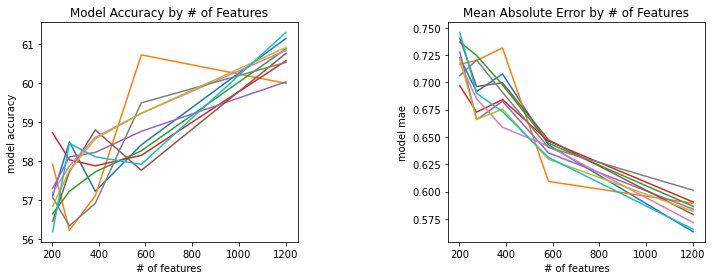

In [39]:
# draw plot of model accuracy and mae evaluated from 10 runs

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

for y_accuracy in y_accuracy_list:
    ax1.plot(x_features_size, y_accuracy)
    
ax1.set_title('Model Accuracy by # of Features')
ax1.set(xlabel='# of features', ylabel='model accuracy')

for y_mae in y_mae_list:
    ax2.plot(x_features_size, y_mae)
ax2.set_title('Mean Absolute Error by # of Features')
ax2.set(xlabel='# of features', ylabel='model mae')


plt.tight_layout(w_pad=10, h_pad=1.0)
fig.savefig('model_evaluation.jpg')

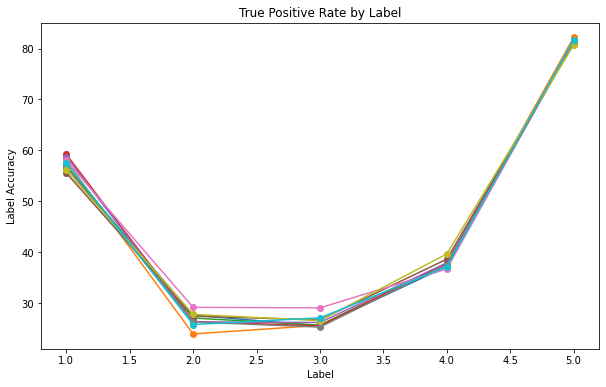

In [40]:
# draw average true positive rate by label evaluated from 10 runs
fig3, ax3 = plt.subplots(1,1, figsize=(10, 6))
for y_label in y_accuracy_by_label_list1:
    ax3.plot([1,2,3,4,5], y_label, '-o')
ax3.set_title('True Positive Rate by Label')
ax3.set(xlabel='Label', ylabel='Label Accuracy')
fig3.savefig('true_positive_rate_by_label.jpg')

In [44]:
# regrouped model where 1-star and 2-star are one group, and 4-star and 5-star are one group

from sklearn.model_selection import train_test_split
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, MultilabelClassificationEvaluator
from pyspark.mllib.evaluation import MultilabelMetrics
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt


# we select only the features whose frequency passes certain threshold, which can be arbitrary.
# in this practice, we select unigram whose frequency is greater than 200, 
# and bigram whose frequence greater than 50, 
# and trigram whose frequence greater than 10
def regrouped_build_data(data, selected_features):
    selected_data = []
    selected_data_no_length = []
    for data_point in data:
        label = data_point[1]
        features = data_point[0]
        new_features = []
        for f in selected_features:
            if f in features:
                new_features.append(1.0)
            else:
                new_features.append(0.0)
        if label == 1.0: 
            label = 0.0
        elif label == 2.0:
            label = 1.0
        elif label == 3.0 or label == 4.0: 
            label = 2.0
        new_features.append(features['length'])
        selected_data.append(LabeledPoint(label, new_features))
    return selected_data

def regrouped_build_model(data, count, iterations=10):
    def build_features(features, count=100):
        uni_features_dict, bi_features_dict, tri_features_dict = features
        selected_uni_features = {k: v for k, v in sorted(uni_features_dict.items(), key=lambda item: -item[1]) if v > count}
        selected_bi_features = {k: v for k, v in sorted(bi_features_dict.items(), key=lambda item: -item[1]) if v > count * 0.5}
        selected_tri_features = {k: v for k, v in sorted(tri_features_dict.items(), key=lambda item: -item[1]) if v > count * 0.1}
        
        selected_features = [k for k in {**selected_uni_features, **selected_bi_features, **selected_tri_features}]
        return selected_features

    
    
    selected_features = build_features([uni_features_dict,
                                        bi_features_dict,
                                        tri_features_dict], count)
    
    selected_data = regrouped_build_data(data, selected_features)
    train_data, test_data = train_test_split(selected_data, train_size=0.7, shuffle=True)

    lrm = LogisticRegressionWithLBFGS.train(sc.parallelize(train_data), numClasses=5, iterations=iterations)    
    test_data_df = sc.parallelize(test_data)
    predictions = lrm.predict(test_data_df.map(lambda x: x.features))
    labels_and_predictions = test_data_df.map(lambda x: x.label).zip(predictions)
    
    mae = labels_and_predictions.map(lambda x: x[0] - x[1] if x[0] > x[1] else x[1] - x[0]).sum() \
                                                / float(test_data_df.count())

    label_and_prediction_list = labels_and_predictions.collect()

    label_and_prediction_df = spark.createDataFrame(label_and_prediction_list, ['label', 'prediction'])
    dataset = label_and_prediction_df.select(['label', 'prediction'])\
                                    .withColumn('prediction', label_and_prediction_df.prediction.cast(DoubleType()))
    evaluator = MulticlassClassificationEvaluator()

    evaluator.setPredictionCol("prediction")
    model_accuracy = evaluator.evaluate(dataset, {evaluator.metricName: "accuracy"}) * 100
    print("Model accuracy: %.3f%%" % (model_accuracy))
    print('Mean Average Error: %.3f' % mae)
    print("Model F-1: %.3f%%" % (evaluator.evaluate(dataset, {evaluator.metricName: "f1"}) * 100))
    
    accuracy_by_label = []
    for i in range(3):
        label_accuracy = evaluator.evaluate(
                                    dataset, 
                                    {evaluator.metricName: "truePositiveRateByLabel", 
                                     evaluator.metricLabel: float(i)}
                                ) * 100
        accuracy_by_label.append(label_accuracy)
        print(f'True Positive Rate by Label (rating {i+1}): %.3f%%' % label_accuracy)
    return model_accuracy, mae, accuracy_by_label, len(selected_features)


In [45]:
# build a list of regrouped model accuracy and model mae
import matplotlib.pyplot as plt

count_range = [500, 400, 300, 200, 100]
regrouped_x_features_size = []


regrouped_y_accuracy_by_label_list = []
regrouped_y_accuracy_list = []
regrouped_y_mae_list = []

for i in range(10):
    y_accuracy = []
    y_mae = []
    accuracy_by_label_list = []
    for count in count_range:
        print(f'word count = {count}')
        accuracy, mae, accuracy_by_label, features_size = regrouped_build_model(data, count)
        if len(regrouped_x_features_size) < 5:
            regrouped_x_features_size.append(features_size)
        y_accuracy.append(accuracy)
        y_mae.append(mae)
        accuracy_by_label_list.append(accuracy_by_label)
        print('=================================================')
    regrouped_y_accuracy_list.append(y_accuracy)
    regrouped_y_mae_list.append(y_mae)
    regrouped_y_accuracy_by_label_list.append(accuracy_by_label_list)

word count = 500


Model accuracy: 76.808%
Mean Average Error: 0.342
Model F-1: 75.371%
True Positive Rate by Label (rating 1): 59.859%
True Positive Rate by Label (rating 2): 25.177%
True Positive Rate by Label (rating 3): 90.629%
word count = 400


Model accuracy: 77.654%
Mean Average Error: 0.320
Model F-1: 76.174%
True Positive Rate by Label (rating 1): 63.511%
True Positive Rate by Label (rating 2): 22.887%
True Positive Rate by Label (rating 3): 91.354%
word count = 300


Model accuracy: 80.462%
Mean Average Error: 0.283
Model F-1: 79.635%
True Positive Rate by Label (rating 1): 71.880%
True Positive Rate by Label (rating 2): 29.457%
True Positive Rate by Label (rating 3): 90.637%
word count = 200


Model accuracy: 78.654%
Mean Average Error: 0.297
Model F-1: 77.921%
True Positive Rate by Label (rating 1): 61.897%
True Positive Rate by Label (rating 2): 33.929%
True Positive Rate by Label (rating 3): 91.437%
word count = 100


Model accuracy: 80.538%
Mean Average Error: 0.262
Model F-1: 80.007%
True Positive Rate by Label (rating 1): 66.546%
True Positive Rate by Label (rating 2): 33.333%
True Positive Rate by Label (rating 3): 91.966%
word count = 500


Model accuracy: 78.385%
Mean Average Error: 0.314
Model F-1: 77.065%
True Positive Rate by Label (rating 1): 60.239%
True Positive Rate by Label (rating 2): 25.954%
True Positive Rate by Label (rating 3): 92.295%
word count = 400


Model accuracy: 76.923%
Mean Average Error: 0.330
Model F-1: 75.471%
True Positive Rate by Label (rating 1): 58.725%
True Positive Rate by Label (rating 2): 22.909%
True Positive Rate by Label (rating 3): 91.787%
word count = 300


Model accuracy: 78.462%
Mean Average Error: 0.315
Model F-1: 76.777%
True Positive Rate by Label (rating 1): 65.695%
True Positive Rate by Label (rating 2): 21.942%
True Positive Rate by Label (rating 3): 91.777%
word count = 200


Model accuracy: 79.692%
Mean Average Error: 0.276
Model F-1: 78.910%
True Positive Rate by Label (rating 1): 62.304%
True Positive Rate by Label (rating 2): 31.734%
True Positive Rate by Label (rating 3): 92.768%
word count = 100


Model accuracy: 81.654%
Mean Average Error: 0.249
Model F-1: 81.129%
True Positive Rate by Label (rating 1): 67.731%
True Positive Rate by Label (rating 2): 39.114%
True Positive Rate by Label (rating 3): 93.080%
word count = 500
Model accuracy: 77.269%
Mean Average Error: 0.336
Model F-1: 75.962%
True Positive Rate by Label (rating 1): 58.865%
True Positive Rate by Label (rating 2): 28.159%
True Positive Rate by Label (rating 3): 90.904%
word count = 400
Model accuracy: 77.615%
Mean Average Error: 0.328
Model F-1: 75.873%
True Positive Rate by Label (rating 1): 57.666%
True Positive Rate by Label (rating 2): 19.844%
True Positive Rate by Label (rating 3): 92.482%
word count = 300


Model accuracy: 79.154%
Mean Average Error: 0.301
Model F-1: 77.804%
True Positive Rate by Label (rating 1): 70.619%
True Positive Rate by Label (rating 2): 23.297%
True Positive Rate by Label (rating 3): 90.972%
word count = 200


Model accuracy: 79.769%
Mean Average Error: 0.283
Model F-1: 78.501%
True Positive Rate by Label (rating 1): 73.183%
True Positive Rate by Label (rating 2): 22.059%
True Positive Rate by Label (rating 3): 90.914%
word count = 100


Model accuracy: 79.692%
Mean Average Error: 0.282
Model F-1: 79.275%
True Positive Rate by Label (rating 1): 61.864%
True Positive Rate by Label (rating 2): 38.996%
True Positive Rate by Label (rating 3): 91.719%
word count = 500
Model accuracy: 77.615%
Mean Average Error: 0.335
Model F-1: 75.969%
True Positive Rate by Label (rating 1): 55.465%
True Positive Rate by Label (rating 2): 23.887%
True Positive Rate by Label (rating 3): 93.046%
word count = 400


Model accuracy: 77.923%
Mean Average Error: 0.310
Model F-1: 76.635%
True Positive Rate by Label (rating 1): 63.781%
True Positive Rate by Label (rating 2): 22.939%
True Positive Rate by Label (rating 3): 91.225%
word count = 300


Model accuracy: 79.115%
Mean Average Error: 0.300
Model F-1: 77.570%
True Positive Rate by Label (rating 1): 59.259%
True Positive Rate by Label (rating 2): 26.296%
True Positive Rate by Label (rating 3): 93.590%
word count = 200


Model accuracy: 79.577%
Mean Average Error: 0.289
Model F-1: 78.537%
True Positive Rate by Label (rating 1): 63.054%
True Positive Rate by Label (rating 2): 30.566%
True Positive Rate by Label (rating 3): 92.932%
word count = 100


Model accuracy: 81.346%
Mean Average Error: 0.248
Model F-1: 80.903%
True Positive Rate by Label (rating 1): 67.233%
True Positive Rate by Label (rating 2): 35.385%
True Positive Rate by Label (rating 3): 92.918%
word count = 500


Model accuracy: 77.769%
Mean Average Error: 0.324
Model F-1: 76.404%
True Positive Rate by Label (rating 1): 58.744%
True Positive Rate by Label (rating 2): 25.191%
True Positive Rate by Label (rating 3): 92.053%
word count = 400


Model accuracy: 77.538%
Mean Average Error: 0.331
Model F-1: 76.286%
True Positive Rate by Label (rating 1): 65.210%
True Positive Rate by Label (rating 2): 21.094%
True Positive Rate by Label (rating 3): 89.994%
word count = 300


Model accuracy: 77.231%
Mean Average Error: 0.325
Model F-1: 76.207%
True Positive Rate by Label (rating 1): 54.949%
True Positive Rate by Label (rating 2): 32.472%
True Positive Rate by Label (rating 3): 91.681%
word count = 200


Model accuracy: 79.731%
Mean Average Error: 0.287
Model F-1: 78.760%
True Positive Rate by Label (rating 1): 60.549%
True Positive Rate by Label (rating 2): 31.518%
True Positive Rate by Label (rating 3): 93.125%
word count = 100


Model accuracy: 82.077%
Mean Average Error: 0.238
Model F-1: 81.569%
True Positive Rate by Label (rating 1): 67.025%
True Positive Rate by Label (rating 2): 38.060%
True Positive Rate by Label (rating 3): 93.461%
word count = 500


Model accuracy: 76.962%
Mean Average Error: 0.341
Model F-1: 75.281%
True Positive Rate by Label (rating 1): 56.973%
True Positive Rate by Label (rating 2): 23.048%
True Positive Rate by Label (rating 3): 92.025%
word count = 400
Model accuracy: 77.962%
Mean Average Error: 0.323
Model F-1: 76.282%
True Positive Rate by Label (rating 1): 68.348%
True Positive Rate by Label (rating 2): 21.453%
True Positive Rate by Label (rating 3): 90.553%
word count = 300


Model accuracy: 78.923%
Mean Average Error: 0.309
Model F-1: 77.385%
True Positive Rate by Label (rating 1): 75.387%
True Positive Rate by Label (rating 2): 20.789%
True Positive Rate by Label (rating 3): 89.425%
word count = 200


Model accuracy: 79.577%
Mean Average Error: 0.281
Model F-1: 78.866%
True Positive Rate by Label (rating 1): 61.436%
True Positive Rate by Label (rating 2): 31.225%
True Positive Rate by Label (rating 3): 92.792%
word count = 100


Model accuracy: 81.885%
Mean Average Error: 0.250
Model F-1: 81.673%
True Positive Rate by Label (rating 1): 69.799%
True Positive Rate by Label (rating 2): 40.816%
True Positive Rate by Label (rating 3): 91.700%
word count = 500
Model accuracy: 77.269%
Mean Average Error: 0.340
Model F-1: 75.947%
True Positive Rate by Label (rating 1): 57.923%
True Positive Rate by Label (rating 2): 26.136%
True Positive Rate by Label (rating 3): 90.767%
word count = 400


Model accuracy: 79.231%
Mean Average Error: 0.295
Model F-1: 77.964%
True Positive Rate by Label (rating 1): 62.832%
True Positive Rate by Label (rating 2): 26.766%
True Positive Rate by Label (rating 3): 92.469%
word count = 300


Model accuracy: 79.308%
Mean Average Error: 0.301
Model F-1: 77.996%
True Positive Rate by Label (rating 1): 59.294%
True Positive Rate by Label (rating 2): 30.909%
True Positive Rate by Label (rating 3): 92.781%
word count = 200


Model accuracy: 79.577%
Mean Average Error: 0.278
Model F-1: 79.003%
True Positive Rate by Label (rating 1): 64.602%
True Positive Rate by Label (rating 2): 37.966%
True Positive Rate by Label (rating 3): 91.494%
word count = 100


Model accuracy: 81.731%
Mean Average Error: 0.247
Model F-1: 81.171%
True Positive Rate by Label (rating 1): 66.779%
True Positive Rate by Label (rating 2): 35.178%
True Positive Rate by Label (rating 3): 93.547%
word count = 500


Model accuracy: 77.923%
Mean Average Error: 0.318
Model F-1: 76.200%
True Positive Rate by Label (rating 1): 58.511%
True Positive Rate by Label (rating 2): 21.033%
True Positive Rate by Label (rating 3): 92.861%
word count = 400


Model accuracy: 79.538%
Mean Average Error: 0.303
Model F-1: 78.267%
True Positive Rate by Label (rating 1): 60.179%
True Positive Rate by Label (rating 2): 28.514%
True Positive Rate by Label (rating 3): 92.686%
word count = 300


Model accuracy: 78.962%
Mean Average Error: 0.300
Model F-1: 77.696%
True Positive Rate by Label (rating 1): 66.372%
True Positive Rate by Label (rating 2): 25.091%
True Positive Rate by Label (rating 3): 91.420%
word count = 200


Model accuracy: 78.962%
Mean Average Error: 0.294
Model F-1: 78.049%
True Positive Rate by Label (rating 1): 59.609%
True Positive Rate by Label (rating 2): 30.888%
True Positive Rate by Label (rating 3): 93.052%
word count = 100


Model accuracy: 81.885%
Mean Average Error: 0.242
Model F-1: 81.126%
True Positive Rate by Label (rating 1): 72.991%
True Positive Rate by Label (rating 2): 32.734%
True Positive Rate by Label (rating 3): 92.746%
word count = 500


Model accuracy: 77.962%
Mean Average Error: 0.325
Model F-1: 76.738%
True Positive Rate by Label (rating 1): 57.527%
True Positive Rate by Label (rating 2): 26.316%
True Positive Rate by Label (rating 3): 91.421%
word count = 400
Model accuracy: 78.308%
Mean Average Error: 0.312
Model F-1: 76.778%
True Positive Rate by Label (rating 1): 64.311%
True Positive Rate by Label (rating 2): 25.589%
True Positive Rate by Label (rating 3): 91.883%
word count = 300


Model accuracy: 77.654%
Mean Average Error: 0.318
Model F-1: 76.362%
True Positive Rate by Label (rating 1): 57.119%
True Positive Rate by Label (rating 2): 29.181%
True Positive Rate by Label (rating 3): 92.539%
word count = 200


Model accuracy: 79.923%
Mean Average Error: 0.287
Model F-1: 78.730%
True Positive Rate by Label (rating 1): 61.702%
True Positive Rate by Label (rating 2): 32.472%
True Positive Rate by Label (rating 3): 93.888%
word count = 100


Model accuracy: 80.885%
Mean Average Error: 0.250
Model F-1: 80.193%
True Positive Rate by Label (rating 1): 67.979%
True Positive Rate by Label (rating 2): 31.915%
True Positive Rate by Label (rating 3): 92.837%
word count = 500


Model accuracy: 78.000%
Mean Average Error: 0.319
Model F-1: 76.741%
True Positive Rate by Label (rating 1): 57.829%
True Positive Rate by Label (rating 2): 23.790%
True Positive Rate by Label (rating 3): 91.844%
word count = 400


Model accuracy: 77.692%
Mean Average Error: 0.315
Model F-1: 76.375%
True Positive Rate by Label (rating 1): 59.619%
True Positive Rate by Label (rating 2): 28.859%
True Positive Rate by Label (rating 3): 92.174%
word count = 300


Model accuracy: 77.385%
Mean Average Error: 0.316
Model F-1: 76.536%
True Positive Rate by Label (rating 1): 58.685%
True Positive Rate by Label (rating 2): 31.047%
True Positive Rate by Label (rating 3): 91.214%
word count = 200


Model accuracy: 78.577%
Mean Average Error: 0.302
Model F-1: 77.881%
True Positive Rate by Label (rating 1): 55.035%
True Positive Rate by Label (rating 2): 35.743%
True Positive Rate by Label (rating 3): 92.225%
word count = 100


Model accuracy: 82.769%
Mean Average Error: 0.232
Model F-1: 82.541%
True Positive Rate by Label (rating 1): 68.333%
True Positive Rate by Label (rating 2): 44.223%
True Positive Rate by Label (rating 3): 93.253%


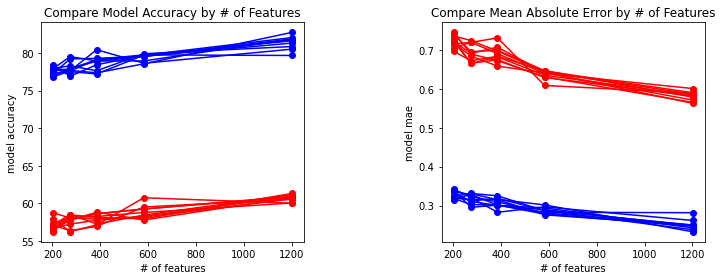

In [46]:
# draw and compare original model accuracy and regrouped model accuracy
fig11, (ax11, ax22) = plt.subplots(1,2, figsize=(10, 4))

for y_accuracy in regrouped_y_accuracy_list:
    ax11.plot(x_features_size, y_accuracy, '-bo')

for y_accuracy in y_accuracy_list:
    ax11.plot(x_features_size, y_accuracy, '-ro')
    
ax11.set_title('Compare Model Accuracy by # of Features')
ax11.set(xlabel='# of features', ylabel='model accuracy')

for y_mae in regrouped_y_mae_list:
    ax22.plot(x_features_size, y_mae, '-bo')

for y_mae in y_mae_list:
    ax22.plot(x_features_size, y_mae, '-ro')
    
ax22.set_title('Compare Mean Absolute Error by # of Features')
ax22.set(xlabel='# of features', ylabel='model mae')


plt.tight_layout(w_pad=10, h_pad=1.0)
fig11.savefig('Compare_model_evaluation.jpg')

In [48]:
# another regroup approach where 2-star & 3-star & 4-star are one group

from sklearn.model_selection import train_test_split
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, MultilabelClassificationEvaluator
from pyspark.mllib.evaluation import MultilabelMetrics
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt


# we select only the features whose frequency passes certain threshold, which can be arbitrary.
# in this practice, we select unigram whose frequency is greater than 200, 
# and bigram whose frequence greater than 50, 
# and trigram whose frequence greater than 10
def regrouped_build_data(data, selected_features):
    selected_data = []
    selected_data_no_length = []
    for data_point in data:
        label = data_point[1]
        features = data_point[0]
        new_features = []
        for f in selected_features:
            if f in features:
                new_features.append(1.0)
            else:
                new_features.append(0.0)
        # 0-4:
        #     0 = 0
        #     1 = 1
        #     2 = 1
        #     3 = 1
        #     4 = 2

        if label == 2.0: 
            label = 1.0
        elif label == 3.0:
            label = 1.0
        elif label == 4.0: 
            label = 2.0
        new_features.append(features['length'])
        selected_data.append(LabeledPoint(label, new_features))
    return selected_data

def regrouped_build_model_2(data, count, iterations=10):
    def build_features(features, count=100):
        uni_features_dict, bi_features_dict, tri_features_dict = features
        selected_uni_features = {k: v for k, v in sorted(uni_features_dict.items(), key=lambda item: -item[1]) if v > count}
        selected_bi_features = {k: v for k, v in sorted(bi_features_dict.items(), key=lambda item: -item[1]) if v > count * 0.5}
        selected_tri_features = {k: v for k, v in sorted(tri_features_dict.items(), key=lambda item: -item[1]) if v > count * 0.1}
        
        selected_features = [k for k in {**selected_uni_features, **selected_bi_features, **selected_tri_features}]
        return selected_features

    
    
    selected_features = build_features([uni_features_dict,
                                        bi_features_dict,
                                        tri_features_dict], count)
    
    selected_data = regrouped_build_data(data, selected_features)
    train_data, test_data = train_test_split(selected_data, train_size=0.7, shuffle=True)

    lrm = LogisticRegressionWithLBFGS.train(sc.parallelize(train_data), numClasses=5, iterations=iterations)    
    test_data_df = sc.parallelize(test_data)
    predictions = lrm.predict(test_data_df.map(lambda x: x.features))
    labels_and_predictions = test_data_df.map(lambda x: x.label).zip(predictions)
    
    mae = labels_and_predictions.map(lambda x: x[0] - x[1] if x[0] > x[1] else x[1] - x[0]).sum() \
                                                / float(test_data_df.count())

    label_and_prediction_list = labels_and_predictions.collect()

    label_and_prediction_df = spark.createDataFrame(label_and_prediction_list, ['label', 'prediction'])
    dataset = label_and_prediction_df.select(['label', 'prediction'])\
                                    .withColumn('prediction', label_and_prediction_df.prediction.cast(DoubleType()))
    evaluator = MulticlassClassificationEvaluator()

    evaluator.setPredictionCol("prediction")
    model_accuracy = evaluator.evaluate(dataset, {evaluator.metricName: "accuracy"}) * 100
    print("Model accuracy: %.3f%%" % (model_accuracy))
    print('Mean Average Error: %.3f' % mae)
    print("Model F-1: %.3f%%" % (evaluator.evaluate(dataset, {evaluator.metricName: "f1"}) * 100))
    
    accuracy_by_label = []
    for i in range(3):
        label_accuracy = evaluator.evaluate(
                                    dataset, 
                                    {evaluator.metricName: "truePositiveRateByLabel", 
                                     evaluator.metricLabel: float(i)}
                                ) * 100
        accuracy_by_label.append(label_accuracy)
        print(f'True Positive Rate by Label (rating {i+1}): %.3f%%' % label_accuracy)
    return model_accuracy, mae, accuracy_by_label, len(selected_features)


In [49]:
# have 10 runs and evaluation of model built with the second regrouped approach
import matplotlib.pyplot as plt

count_range = [500, 400, 300, 200, 100]
regrouped_x_features_size_2 = []


regrouped_y_accuracy_by_label_list_2 = []
regrouped_y_accuracy_list_2 = []
regrouped_y_mae_list_2 = []

for i in range(10):
    y_accuracy = []
    y_mae = []
    accuracy_by_label_list = []
    for count in count_range:
        print(f'word count = {count}')
        accuracy, mae, accuracy_by_label, features_size = regrouped_build_model_2(data, count)
        if len(regrouped_x_features_size_2) < 5:
            regrouped_x_features_size_2.append(features_size)
        y_accuracy.append(accuracy)
        y_mae.append(mae)
        accuracy_by_label_list.append(accuracy_by_label)
        print('=================================================')
    regrouped_y_accuracy_list_2.append(y_accuracy)
    regrouped_y_mae_list_2.append(y_mae)
    regrouped_y_accuracy_by_label_list_2.append(accuracy_by_label_list)

word count = 500


Model accuracy: 67.462%
Mean Average Error: 0.356
Model F-1: 67.317%
True Positive Rate by Label (rating 1): 56.764%
True Positive Rate by Label (rating 2): 62.704%
True Positive Rate by Label (rating 3): 75.085%
word count = 400


Model accuracy: 68.192%
Mean Average Error: 0.351
Model F-1: 67.963%
True Positive Rate by Label (rating 1): 59.269%
True Positive Rate by Label (rating 2): 61.106%
True Positive Rate by Label (rating 3): 77.234%
word count = 300


Model accuracy: 68.462%
Mean Average Error: 0.347
Model F-1: 68.257%
True Positive Rate by Label (rating 1): 63.456%
True Positive Rate by Label (rating 2): 59.728%
True Positive Rate by Label (rating 3): 77.276%
word count = 200


Model accuracy: 69.846%
Mean Average Error: 0.327
Model F-1: 69.696%
True Positive Rate by Label (rating 1): 60.202%
True Positive Rate by Label (rating 2): 64.609%
True Positive Rate by Label (rating 3): 77.787%
word count = 100


Model accuracy: 70.462%
Mean Average Error: 0.311
Model F-1: 70.256%
True Positive Rate by Label (rating 1): 62.185%
True Positive Rate by Label (rating 2): 63.653%
True Positive Rate by Label (rating 3): 79.379%
word count = 500


Model accuracy: 67.346%
Mean Average Error: 0.359
Model F-1: 67.126%
True Positive Rate by Label (rating 1): 50.140%
True Positive Rate by Label (rating 2): 64.368%
True Positive Rate by Label (rating 3): 75.063%
word count = 400


Model accuracy: 69.077%
Mean Average Error: 0.339
Model F-1: 68.981%
True Positive Rate by Label (rating 1): 62.245%
True Positive Rate by Label (rating 2): 63.969%
True Positive Rate by Label (rating 3): 75.897%
word count = 300


Model accuracy: 68.808%
Mean Average Error: 0.341
Model F-1: 68.474%
True Positive Rate by Label (rating 1): 56.464%
True Positive Rate by Label (rating 2): 60.588%
True Positive Rate by Label (rating 3): 79.684%
word count = 200


Model accuracy: 70.269%
Mean Average Error: 0.319
Model F-1: 70.215%
True Positive Rate by Label (rating 1): 61.186%
True Positive Rate by Label (rating 2): 66.145%
True Positive Rate by Label (rating 3): 76.553%
word count = 100


Model accuracy: 69.231%
Mean Average Error: 0.331
Model F-1: 69.273%
True Positive Rate by Label (rating 1): 66.398%
True Positive Rate by Label (rating 2): 66.248%
True Positive Rate by Label (rating 3): 72.697%
word count = 500


Model accuracy: 68.654%
Mean Average Error: 0.348
Model F-1: 68.383%
True Positive Rate by Label (rating 1): 50.407%
True Positive Rate by Label (rating 2): 66.604%
True Positive Rate by Label (rating 3): 76.260%
word count = 400


Model accuracy: 67.462%
Mean Average Error: 0.362
Model F-1: 67.276%
True Positive Rate by Label (rating 1): 53.351%
True Positive Rate by Label (rating 2): 64.695%
True Positive Rate by Label (rating 3): 74.656%
word count = 300


Model accuracy: 67.654%
Mean Average Error: 0.353
Model F-1: 67.489%
True Positive Rate by Label (rating 1): 56.787%
True Positive Rate by Label (rating 2): 63.207%
True Positive Rate by Label (rating 3): 75.172%
word count = 200


Model accuracy: 68.769%
Mean Average Error: 0.332
Model F-1: 68.725%
True Positive Rate by Label (rating 1): 61.538%
True Positive Rate by Label (rating 2): 65.659%
True Positive Rate by Label (rating 3): 73.898%
word count = 100


Model accuracy: 70.500%
Mean Average Error: 0.313
Model F-1: 70.403%
True Positive Rate by Label (rating 1): 62.857%
True Positive Rate by Label (rating 2): 65.092%
True Positive Rate by Label (rating 3): 77.759%
word count = 500


Model accuracy: 68.654%
Mean Average Error: 0.348
Model F-1: 68.403%
True Positive Rate by Label (rating 1): 54.133%
True Positive Rate by Label (rating 2): 63.320%
True Positive Rate by Label (rating 3): 77.523%
word count = 400


Model accuracy: 67.192%
Mean Average Error: 0.365
Model F-1: 67.017%
True Positive Rate by Label (rating 1): 55.135%
True Positive Rate by Label (rating 2): 62.895%
True Positive Rate by Label (rating 3): 74.726%
word count = 300


Model accuracy: 68.500%
Mean Average Error: 0.348
Model F-1: 68.331%
True Positive Rate by Label (rating 1): 55.978%
True Positive Rate by Label (rating 2): 64.408%
True Positive Rate by Label (rating 3): 76.014%
word count = 200


Model accuracy: 69.346%
Mean Average Error: 0.325
Model F-1: 69.036%
True Positive Rate by Label (rating 1): 63.202%
True Positive Rate by Label (rating 2): 59.542%
True Positive Rate by Label (rating 3): 79.766%
word count = 100


Model accuracy: 70.115%
Mean Average Error: 0.320
Model F-1: 70.017%
True Positive Rate by Label (rating 1): 61.697%
True Positive Rate by Label (rating 2): 65.322%
True Positive Rate by Label (rating 3): 77.179%
word count = 500


Model accuracy: 66.885%
Mean Average Error: 0.362
Model F-1: 66.669%
True Positive Rate by Label (rating 1): 54.354%
True Positive Rate by Label (rating 2): 61.968%
True Positive Rate by Label (rating 3): 75.430%
word count = 400


Model accuracy: 67.538%
Mean Average Error: 0.358
Model F-1: 67.416%
True Positive Rate by Label (rating 1): 53.209%
True Positive Rate by Label (rating 2): 64.436%
True Positive Rate by Label (rating 3): 74.449%
word count = 300


Model accuracy: 69.308%
Mean Average Error: 0.337
Model F-1: 69.147%
True Positive Rate by Label (rating 1): 60.053%
True Positive Rate by Label (rating 2): 63.733%
True Positive Rate by Label (rating 3): 77.104%
word count = 200


Model accuracy: 69.462%
Mean Average Error: 0.333
Model F-1: 69.358%
True Positive Rate by Label (rating 1): 63.198%
True Positive Rate by Label (rating 2): 63.037%
True Positive Rate by Label (rating 3): 76.846%
word count = 100


Model accuracy: 68.538%
Mean Average Error: 0.335
Model F-1: 68.546%
True Positive Rate by Label (rating 1): 59.654%
True Positive Rate by Label (rating 2): 67.590%
True Positive Rate by Label (rating 3): 72.051%
word count = 500


Model accuracy: 67.692%
Mean Average Error: 0.356
Model F-1: 67.550%
True Positive Rate by Label (rating 1): 52.394%
True Positive Rate by Label (rating 2): 65.179%
True Positive Rate by Label (rating 3): 74.507%
word count = 400
Model accuracy: 67.077%
Mean Average Error: 0.363
Model F-1: 66.783%
True Positive Rate by Label (rating 1): 56.728%
True Positive Rate by Label (rating 2): 59.560%
True Positive Rate by Label (rating 3): 77.106%
word count = 300


Model accuracy: 68.769%
Mean Average Error: 0.343
Model F-1: 68.656%
True Positive Rate by Label (rating 1): 62.778%
True Positive Rate by Label (rating 2): 62.463%
True Positive Rate by Label (rating 3): 75.755%
word count = 200


Model accuracy: 71.385%
Mean Average Error: 0.307
Model F-1: 71.176%
True Positive Rate by Label (rating 1): 65.591%
True Positive Rate by Label (rating 2): 62.988%
True Positive Rate by Label (rating 3): 80.316%
word count = 100


Model accuracy: 68.462%
Mean Average Error: 0.333
Model F-1: 68.366%
True Positive Rate by Label (rating 1): 56.461%
True Positive Rate by Label (rating 2): 63.883%
True Positive Rate by Label (rating 3): 75.865%
word count = 500
Model accuracy: 68.269%
Mean Average Error: 0.349
Model F-1: 68.003%
True Positive Rate by Label (rating 1): 53.351%
True Positive Rate by Label (rating 2): 62.660%
True Positive Rate by Label (rating 3): 77.558%
word count = 400


Model accuracy: 68.538%
Mean Average Error: 0.345
Model F-1: 68.453%
True Positive Rate by Label (rating 1): 57.064%
True Positive Rate by Label (rating 2): 64.931%
True Positive Rate by Label (rating 3): 74.939%
word count = 300


Model accuracy: 68.346%
Mean Average Error: 0.347
Model F-1: 68.219%
True Positive Rate by Label (rating 1): 56.168%
True Positive Rate by Label (rating 2): 66.110%
True Positive Rate by Label (rating 3): 74.518%
word count = 200


Model accuracy: 69.538%
Mean Average Error: 0.331
Model F-1: 69.387%
True Positive Rate by Label (rating 1): 59.892%
True Positive Rate by Label (rating 2): 63.584%
True Positive Rate by Label (rating 3): 77.703%
word count = 100


Model accuracy: 69.115%
Mean Average Error: 0.331
Model F-1: 68.935%
True Positive Rate by Label (rating 1): 62.016%
True Positive Rate by Label (rating 2): 62.190%
True Positive Rate by Label (rating 3): 77.730%
word count = 500
Model accuracy: 68.115%
Mean Average Error: 0.354
Model F-1: 67.925%
True Positive Rate by Label (rating 1): 57.702%
True Positive Rate by Label (rating 2): 62.181%
True Positive Rate by Label (rating 3): 76.480%
word count = 400


Model accuracy: 68.192%
Mean Average Error: 0.350
Model F-1: 68.073%
True Positive Rate by Label (rating 1): 57.743%
True Positive Rate by Label (rating 2): 63.985%
True Positive Rate by Label (rating 3): 75.319%
word count = 300


Model accuracy: 68.231%
Mean Average Error: 0.351
Model F-1: 67.970%
True Positive Rate by Label (rating 1): 59.459%
True Positive Rate by Label (rating 2): 60.291%
True Positive Rate by Label (rating 3): 77.750%
word count = 200


Model accuracy: 69.500%
Mean Average Error: 0.328
Model F-1: 69.312%
True Positive Rate by Label (rating 1): 60.800%
True Positive Rate by Label (rating 2): 62.788%
True Positive Rate by Label (rating 3): 78.143%
word count = 100


Model accuracy: 68.577%
Mean Average Error: 0.335
Model F-1: 68.454%
True Positive Rate by Label (rating 1): 65.147%
True Positive Rate by Label (rating 2): 61.281%
True Positive Rate by Label (rating 3): 76.122%
word count = 500


Model accuracy: 68.346%
Mean Average Error: 0.349
Model F-1: 68.058%
True Positive Rate by Label (rating 1): 54.155%
True Positive Rate by Label (rating 2): 62.797%
True Positive Rate by Label (rating 3): 77.806%
word count = 400


Model accuracy: 67.731%
Mean Average Error: 0.355
Model F-1: 67.603%
True Positive Rate by Label (rating 1): 61.918%
True Positive Rate by Label (rating 2): 62.243%
True Positive Rate by Label (rating 3): 74.592%
word count = 300


Model accuracy: 68.577%
Mean Average Error: 0.339
Model F-1: 68.380%
True Positive Rate by Label (rating 1): 63.492%
True Positive Rate by Label (rating 2): 60.445%
True Positive Rate by Label (rating 3): 77.273%
word count = 200


Model accuracy: 70.308%
Mean Average Error: 0.324
Model F-1: 70.099%
True Positive Rate by Label (rating 1): 60.870%
True Positive Rate by Label (rating 2): 63.619%
True Positive Rate by Label (rating 3): 79.044%
word count = 100


Model accuracy: 70.462%
Mean Average Error: 0.310
Model F-1: 70.371%
True Positive Rate by Label (rating 1): 62.117%
True Positive Rate by Label (rating 2): 65.213%
True Positive Rate by Label (rating 3): 77.656%
word count = 500


Model accuracy: 68.808%
Mean Average Error: 0.342
Model F-1: 68.658%
True Positive Rate by Label (rating 1): 60.322%
True Positive Rate by Label (rating 2): 63.173%
True Positive Rate by Label (rating 3): 76.411%
word count = 400


Model accuracy: 68.269%
Mean Average Error: 0.349
Model F-1: 68.166%
True Positive Rate by Label (rating 1): 62.500%
True Positive Rate by Label (rating 2): 63.037%
True Positive Rate by Label (rating 3): 74.850%
word count = 300


Model accuracy: 68.231%
Mean Average Error: 0.351
Model F-1: 68.097%
True Positive Rate by Label (rating 1): 59.079%
True Positive Rate by Label (rating 2): 64.019%
True Positive Rate by Label (rating 3): 75.022%
word count = 200


Model accuracy: 70.462%
Mean Average Error: 0.315
Model F-1: 70.228%
True Positive Rate by Label (rating 1): 61.436%
True Positive Rate by Label (rating 2): 62.766%
True Positive Rate by Label (rating 3): 80.000%
word count = 100


Model accuracy: 70.192%
Mean Average Error: 0.320
Model F-1: 70.020%
True Positive Rate by Label (rating 1): 63.395%
True Positive Rate by Label (rating 2): 63.559%
True Positive Rate by Label (rating 3): 78.467%


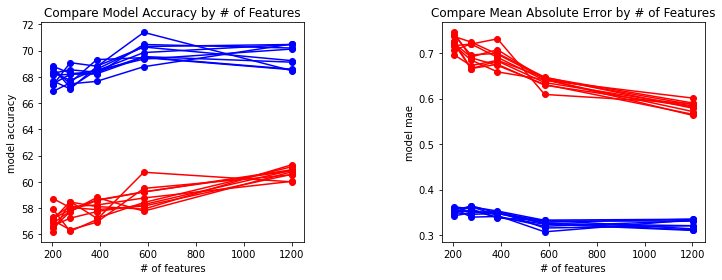

In [50]:
# draw and compare the model accuracy and mae of original model and the second regrouped model

fig111, (ax111, ax222) = plt.subplots(1,2, figsize=(10, 4))


for y_accuracy in regrouped_y_accuracy_list_2:
    ax111.plot(regrouped_x_features_size_2, y_accuracy, '-bo')

for y_accuracy in y_accuracy_list:
    ax111.plot(regrouped_x_features_size_2, y_accuracy, '-ro')
    
ax111.set_title('Compare Model Accuracy by # of Features')
ax111.set(xlabel='# of features', ylabel='model accuracy')

for y_mae in regrouped_y_mae_list_2:
    ax222.plot(regrouped_x_features_size_2, y_mae, '-bo')

for y_mae in y_mae_list:
    ax222.plot(regrouped_x_features_size_2, y_mae, '-ro')
    
ax222.set_title('Compare Mean Absolute Error by # of Features')
ax222.set(xlabel='# of features', ylabel='model mae')


plt.tight_layout(w_pad=10, h_pad=1.0)
fig111.savefig('compare_model_evaluation_2.jpg')

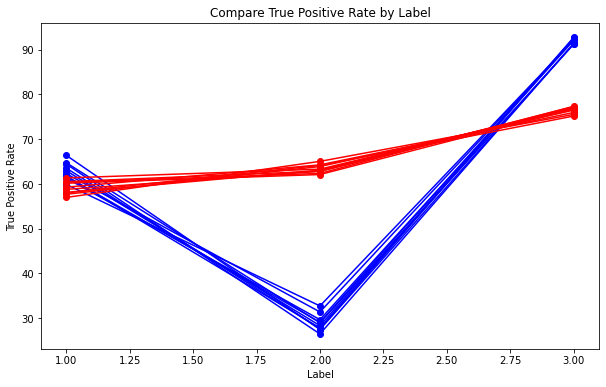

In [53]:
# compare the first regrouped true positive rate by label and the second regrouped true positive rate by label
def build_tpr_by_label(y_accuracy_by_label_list):
    y_accuracy_by_label_list1 = []
    for i in range(len(y_accuracy_by_label_list)):
        sub_list = [0] * len(y_accuracy_by_label_list[i][0])
        for j in range(len(y_accuracy_by_label_list[i])):

            for k in range(len(y_accuracy_by_label_list[i][j])):
                sub_list[k] += y_accuracy_by_label_list[i][j][k]
        sub_list = [d / 5 for d in sub_list]
        y_accuracy_by_label_list1.append(sub_list)
    return y_accuracy_by_label_list1

fig33, ax33 = plt.subplots(1,1, figsize=(10, 6))
for y_label in build_tpr_by_label(regrouped_y_accuracy_by_label_list):
    ax33.plot([1,2,3], y_label, '-bo')

for y_label in build_tpr_by_label(regrouped_y_accuracy_by_label_list_2):
    ax33.plot([1,2,3], y_label, '-ro')
    
ax33.set_title('Compare True Positive Rate by Label')
ax33.set(xlabel='Label', ylabel='True Positive Rate')
fig33.savefig('Compare_model_evaluation_by_label.jpg')